# Linear Kalman Filter Implementation Test
## Initializing a Kalman Filter Object
The following sets up an instance of `KalmanFilter` which represents a tracked object which would become an entry in the main hash map for the final implementation. The parameters for now are set up such that the estimated state vector $X \epsilon \rm I\!R^{4}$, where $X = \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \end{bmatrix}$ so the corresponding 

In [96]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np

# constant
dt = 1/50 # the radar refreshes at 50Hz

obj = KalmanFilter(dim_x=4, dim_z=4)
obj.H = np.identity(4)
obj.F = np.array([[1,0,dt,0],
                  [0,1,0,dt], 
                  [0,0,1,0], 
                  [0,0,0,1]])

# initial state
obj.x = np.array([0,0,1,1])
np.fill_diagonal(obj.P, [100 for _ in range(4)])
obj.Q = Q_discrete_white_noise(4, dt, .5**2)

# the measurement error is going to be constant for now
np.fill_diagonal(obj.R, [1**2 for _ in range(4)])

## Making Test Data
At first I need to know if this works at all on some positively correlated data so the following will construct a fake set of data where the object keeps travelling in the positive logitudinal and lateral directions at 1 m/s and all measurements exhibit some standard deviation to simulate a sensor that returns a monomodal Gaussian Distribution.

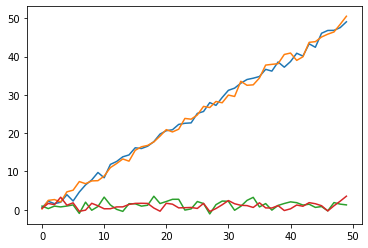

In [98]:
import matplotlib.pyplot as plt

test_x = []
std_dev = 1
for i in range(50):
    test_x.append(np.array([np.random.randn()*std_dev+i, 
                            np.random.randn()*std_dev+i, 
                            np.random.randn()*std_dev+1, 
                            np.random.randn()*std_dev+1]))
test_x = np.asarray(test_x)

plt.plot(test_x)
plt.show()

Now I will see how the filter performs

In [99]:
filtered_x = [] # to track history
for i in range(50):
    obj.predict()
    obj.update(test_x[i])
    filtered_x.append(obj.x)
filtered_x = np.asarray(filtered_x)
y = np.arange(0,1,1/50)

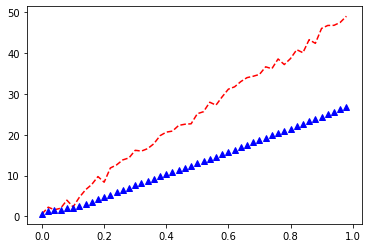

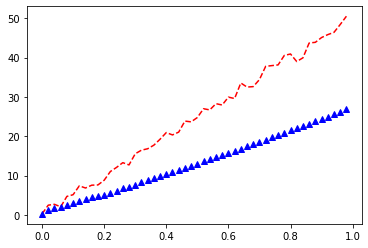

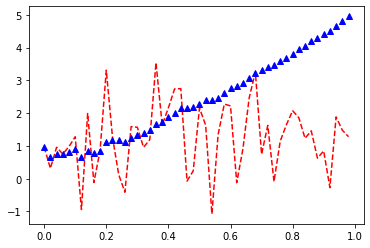

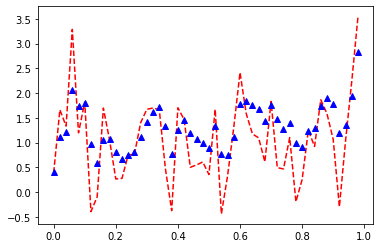

In [100]:
for i in range(4):
    plt.plot(y, test_x[:,i], 'r--', y, filtered_x[:,i], 'b^')
    plt.show()

In [101]:
obj.P

array([[2.44301215e-02, 2.77572410e-05, 9.04716140e-03, 4.75403439e-05],
       [2.77572410e-05, 2.58176653e-02, 4.85204671e-05, 1.14720571e-02],
       [9.04716140e-03, 4.85204671e-05, 1.86064640e-02, 7.43254298e-03],
       [4.75403439e-05, 1.14720571e-02, 7.43254298e-03, 3.90083837e-01]])